In [1]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Model 1

In [2]:
gen_quant = CmdStanModel(stan_file='code1.stan')


INFO:cmdstanpy:found newer exe file, not recompiling


In [21]:
samples = gen_quant.sample( fixed_param=True, 
                            iter_sampling=1000,
                            iter_warmup=0, 
                            chains=1)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [22]:
df = samples.draws_pd()
df

,lp__,accept_stat__,N,p,y
0,0.0,0.0,50.0,0.166820,8.0
1,0.0,0.0,50.0,0.189766,6.0
2,0.0,0.0,50.0,0.189351,10.0
3,0.0,0.0,50.0,0.193370,9.0
4,0.0,0.0,50.0,0.192820,11.0
...,...,...,...,...,...
995,0.0,0.0,50.0,0.202987,12.0
996,0.0,0.0,50.0,0.197995,11.0
997,0.0,0.0,50.0,0.205720,11.0
998,0.0,0.0,50.0,0.219035,7.0


In [25]:
df['p_verify'] = (df.y / 50)
p_verify = df['p_verify'].mean()
p_verify
# it should be close to 20% and it actualy is

0.20000000000000004

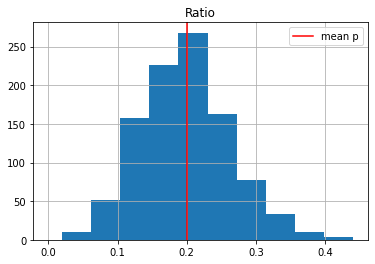

In [35]:
df['p_verify'].hist()
plt.title("Ratio")
plt.axvline(p_verify, color='red', label ="mean p")
plt.legend()
plt.plot(p_verify)

#### Model 2. Modeling posterior and posterior predictive distribution

In [3]:
gen_quant = CmdStanModel(
    stan_file='code2.stan')
samples = gen_quant.sample(data={'N':50, 'y':7})
df = samples.draws_pd()
# Here in stan file Ihad to use some different function than normal_rng because it was forbidden in model structure. 

INFO:cmdstanpy:compiling stan file /home/lab3/code2.stan to exe file /home/lab3/code2
INFO:cmdstanpy:compiled model executable: /home/lab3/code2
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [4]:
df = samples.draws_pd()
df

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,p,y_pred
0,-23.1317,0.954060,0.928432,1.0,1.0,0.0,23.1385,0.176080,11.0
1,-23.1254,1.000000,0.928432,1.0,1.0,0.0,23.2234,0.176203,10.0
2,-22.8589,1.000000,0.928432,1.0,1.0,0.0,23.0759,0.182445,9.0
3,-22.6540,0.998144,0.928432,1.0,3.0,0.0,22.8712,0.193836,7.0
4,-22.6653,0.997978,0.928432,2.0,3.0,0.0,22.6701,0.191649,11.0
...,...,...,...,...,...,...,...,...,...
3995,-23.0433,0.825052,0.958944,1.0,3.0,0.0,24.2283,0.177875,10.0
3996,-22.6687,0.853183,0.958944,2.0,3.0,0.0,24.3842,0.191262,8.0
3997,-22.6773,0.986769,0.958944,2.0,3.0,0.0,22.7771,0.198755,5.0
3998,-22.6717,0.954941,0.958944,2.0,3.0,0.0,22.9893,0.190951,9.0


In [5]:
df['pred_ratio'] = (df.y_pred / 50)
pred_ratio = df['pred_ratio'].mean()
pred_ratio


0.19127500000000003

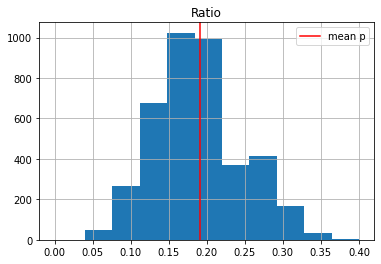

In [6]:
df['pred_ratio'].hist()
plt.title("Ratio")
plt.axvline(pred_ratio, color='red', label ="mean p")
plt.legend()
plt.plot(pred_ratio)

In [7]:
ratio_array = df['pred_ratio'].to_numpy()
p = df['p'].to_numpy()
ratio_ = az.hdi(ratio_array, hdi_prob=0.94)
p_ = az.hdi(p, hdi_prob=0.94)
print(ratio_)
print(p_)
# we expect the ratio to be 0.1912 and 94% of it is between 0.1 and 0.3
# The p is expected to be 0.2 and 94% of it is equal between 0.154733 and 0.226272 

[0.1 0.3]
[0.154733 0.226272]


In [11]:
smaller_ratio = (ratio_array < 0.2).sum()
probability = smaller_ratio/len(ratio_array)
print(smaller_ratio)
print(probability)
# Number of ratio smaller than 20% is 2017
# probability of smaller ratio is around 50%

2017
0.50425
